# FRED - CASS Freight Analysis

In this notebook, I use the FRED API to explore the CASS Freight Index. I specifically want to learn about the seasonality of freight volumes. I have been working in the transportation industry for around 6 months now - and want to solidify high level market concepts to better facilitate pricing strategy in the future. 

My resources used:
> https://github.com/mortada/fredapi - Some explanations for using FRED API in Python

> https://mortada.net/python-api-for-fred.html - Some more examples of using FRED API in Python

> https://www.cassinfo.com/freight-audit-payment/cass-transportation-indexes/december-2022
    - This gives an explanation and brief description of the index

In [1]:
!pip install fredapi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from fredapi import Fred
import creds

pd.set_option('display.max_columns',500)
plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Create the FRED Object

In [3]:
fred = Fred(api_key = creds.fred_key)

# Search FRED

In [4]:
sp_search = fred.search('CASS FREIGHT INDEX', order_by = 'popularity')

In [5]:
sp_search.head(5)

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
FRGSHPUSM649NCIS,FRGSHPUSM649NCIS,2023-01-16,2023-01-16,Cass Freight Index: Shipments,1990-01-01,2022-12-01,Monthly,M,Index Jan 1990=1,Index Jan 1990=1,Not Seasonally Adjusted,NSA,2023-01-12 13:48:02-06:00,55,The Cass Freight Index uses January 1990 as it...
FRGEXPUSM649NCIS,FRGEXPUSM649NCIS,2023-01-16,2023-01-16,Cass Freight Index: Expenditures,1990-01-01,2022-12-01,Monthly,M,Index Jan 1990=1,Index Jan 1990=1,Not Seasonally Adjusted,NSA,2023-01-12 13:48:03-06:00,29,The Cass Freight Index uses January 1990 as it...


# Pull Data and make some basic plots

Cass Freight Index: Shipments -  is a record of volume. Its important to note that it includes all forms of transportation - TL, LTL, Flatbed, Dryvan etc. This matters becuase different modes of transportation tend to have different types of seasonality and will impact our data. Still, having an overview of the industry is useful. Different modes will typically give more granular insight into different markets. 

In [6]:
cass_shipments = pd.DataFrame(fred.get_series(series_id = 'FRGSHPUSM649NCIS'))

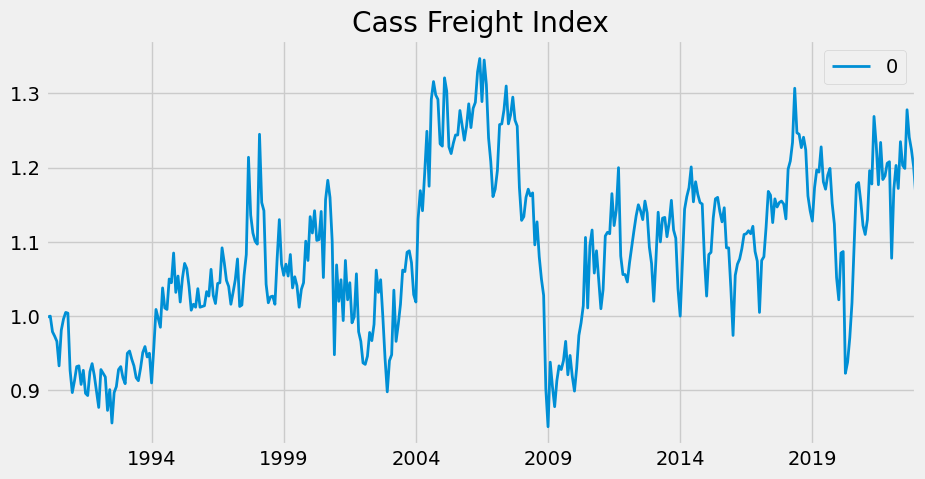

In [7]:
cass_shipments.plot(figsize = (10,5), title = 'Cass Freight Index', lw = 2)
plt.show()

In [ ]:
cass_shipments

,0
1990-01-01,1.000
1990-02-01,0.999
1990-03-01,1.000
1990-04-01,0.979
1990-05-01,0.973
...,...
2022-08-01,1.278
2022-09-01,1.241
2022-10-01,1.224
2022-11-01,1.201


What I want to do is narrow down the years, and then plot them against each other to try to determine seasonality, or patterns in volume. A graph that inculdes all years continuously like the one above is difficult to extract any type of pattern out of. I think constricting the years we use: lets say from 2016 (a few years pre-pandemic to act as a kind of control), to 2022(now post pandemic), and then layering these years, we can see how each month compares to every other month over the years. 

# Prepping the Data

Doing some basic cleaning here to create a date column, rename some columns, and get datatypes right.

In [9]:
cass_shipments['Date'] = cass_shipments.index
cass_shipments['Date'] = pd.to_datetime(cass_shipments['Date'])
cass_shipments = cass_shipments.reset_index(drop = True)

In [11]:
cass_shipments = cass_shipments.rename(columns = {0:"Values"})

I want to seperate the date column into Year and Month, and then map the number we get for month to an actual month name. 

In [72]:
cass_shipments['Year'] = cass_shipments['Date'].dt.year
cass_shipments['Month'] = cass_shipments['Date'].dt.month

In [73]:
month_conversion = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}

In [74]:
cass_shipments['Month'] = cass_shipments['Month'].map(month_conversion)

In [17]:
cass_2022 = cass_shipments[cass_shipments['Year'] == 2022]

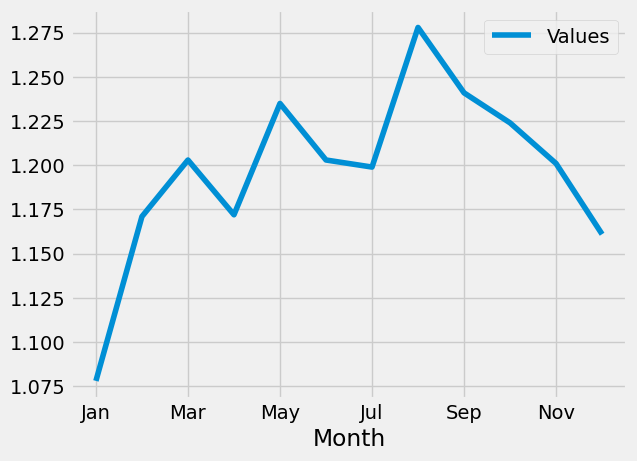

In [43]:
cass_2022.plot('Month', 'Values')
plt.show()

A quick plot to give the mapping a test. The data manipulation should be complete. We can move on to creating our main visualization.

# Comparing Yearly Trends to Determine Market Patterns

In [19]:
years = [2016,2017,2018,2019,2020,2021,2022]

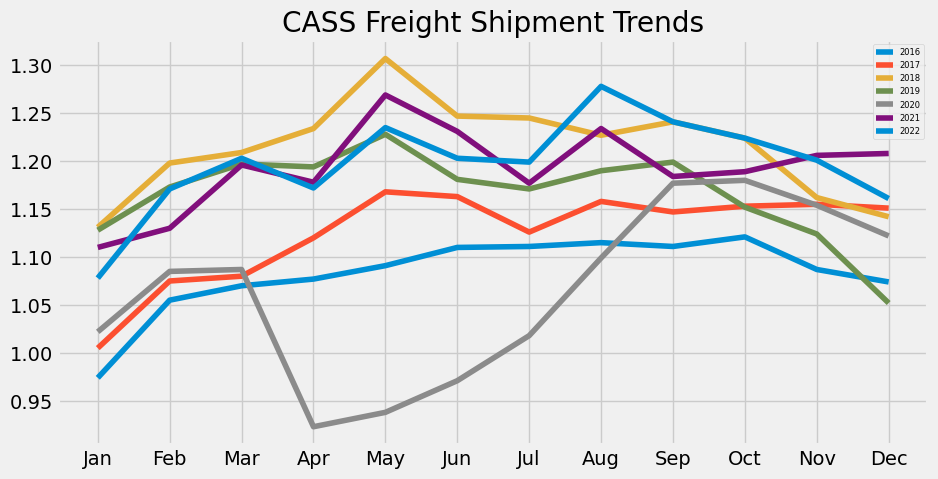

In [20]:
plt.figure(figsize = (10,5))
for i in years:
    cass_plot = cass_shipments[cass_shipments['Year'] == i]
    plt.plot(cass_plot['Month'], cass_plot['Values'], label = i)

plt.legend(prop = {'size':6})
plt.title('CASS Freight Shipment Trends')
plt.show()

This graph is perfect. We can see for the past few years how freight shipments are trending, and even how each year is performing vs others

By looking at this data, we can see:

> Freight shipments typically peak in May. After the big peak in May, volume declines during the summer with a peak again in August.

> After the August peak we see a decline to the end of the year. This is suprising due to how many holidays there are at the end of the year. The shipments in August are most likey for the EOY rush - Black Friday, Thanksgiving, Christmas, etc

> Freight shipments are usually at their lowest at the start of the year - following the decline from the previous year

We have done a decent job at determining the seasonality of freight, but I find it hard, personally, to see what years were doing better than other years overall. Out of curiosity, id like to see this

# Volumes Per Year

In [31]:
cass_plot_means = {}
for i in years:
    cass_plot = cass_shipments[cass_shipments['Year'] == i]
    cass_plot_means[i] = float(cass_plot['Values'].mean())

In [32]:
cass_plot_means = pd.DataFrame.from_dict(cass_plot_means, orient = 'index')
cass_plot_means = cass_plot_means.reset_index()

In [38]:
cass_plot_means = cass_plot_means.rename(columns = {'index':'Year', 0:"Mean"})

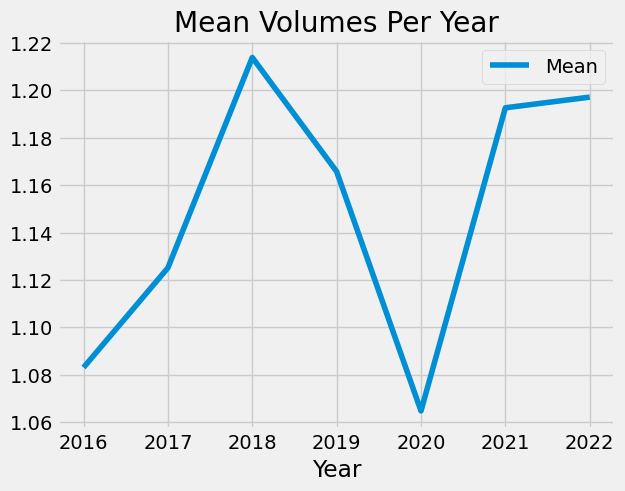

In [42]:
cass_plot_means.plot('Year', 'Mean')
plt.title("Mean Volumes Per Year")
plt.show()

2018 is one of the best freight years in our data in terms of volume of shipments. The story this graph tells us overall is that volume had been steadily increasing with a high in 2018. It started to decline in 2019, and then crash in 2020 - most likley due to COVID conditions. Since then the market has bounced back, but has still yet to match 2018 highs.

Although this graph is good as a high level view, it doesnt hurt to have a more detailed example of this trend

In [69]:
years = [2016,2017,2018,2019,2020,2021,2022]
cass_shipments_2016_to_2022 = cass_shipments[cass_shipments['Year'].isin(years)]

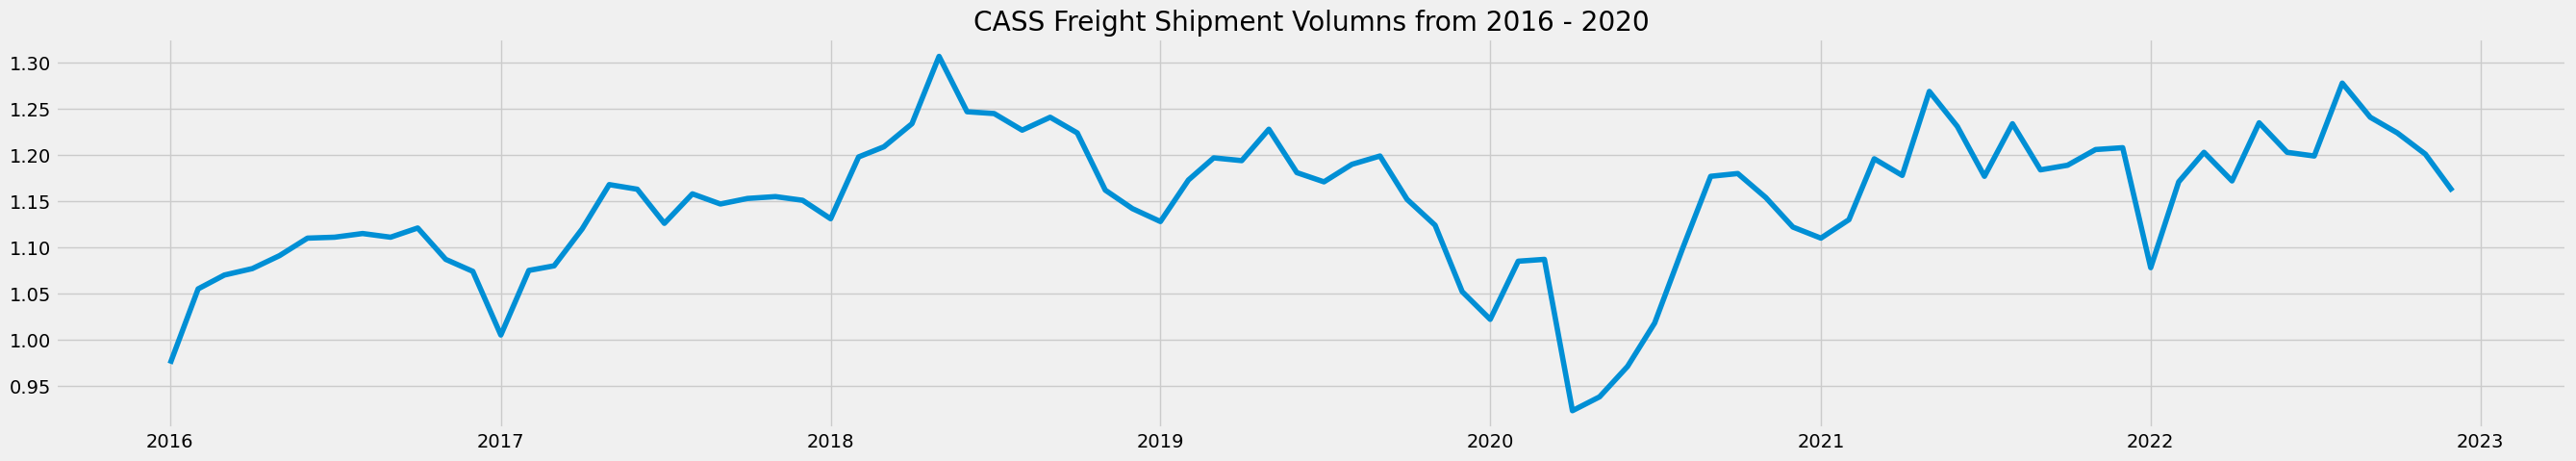

In [71]:
plt.figure(figsize = (30,5))
plt.plot(cass_shipments_2016_to_2022["Date"], cass_shipments_2016_to_2022["Values"])
plt.title("CASS Freight Shipment Volumns from 2016 - 2020")
plt.show()

Do our insights still hold up with this more detailed trend?

*2018 is one of the best freight years in our data in terms of volume of shipments.* ✅

*The story this tells us overall is volume had been steadily increasing with a high in 2018. It started to decline in 2019, and then crash at 2020 - most likley due to COVID-19* ✅

*Since 2020 the market has bounced back, but has still yet to match 2018 highs.* ✅

# Future Questions to Consider

- How fast does the market recover from economic recessions. Example: 2008, Covid

- Compare volumes to expenditure index (also available with FRED API)

- What do expenditures look like in times of recession, and market highs?